# __Title : Exploring techniques to forecast monthly Irish milk sales using time series analysis__

#### _Forecasting of milk sales is essential not only for the consumers but also for the farmers, dairy companies, and policymakers to make informed decisions. In this project we are exploring Time-Series analysis techniques to predict the monthly milk sales (in Million Ltr) in Ireland._ 

### Step 1: Import required libraries

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

!pip install pmdarima --quiet
import pmdarima as pm

import warnings
warnings.filterwarnings('ignore')

Traceback (most recent call last):
  File "C:\Users\NACHIKET\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_internal\utils\temp_dir.py", line 45, in global_tempdir_manager
    yield
  File "C:\Users\NACHIKET\AppData\Local\Programs\Python\Python312\Lib\contextlib.py", line 595, in __exit__
    if cb(*exc_details):
       ^^^^^^^^^^^^^^^^
  File "C:\Users\NACHIKET\AppData\Local\Programs\Python\Python312\Lib\contextlib.py", line 144, in __exit__
    next(self.gen)
  File "C:\Users\NACHIKET\AppData\Local\Programs\Python\Python312\Lib\site-packages\pip\_internal\operations\build\build_tracker.py", line 43, in get_build_tracker
    with contextlib.ExitStack() as ctx:
         ^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\NACHIKET\AppData\Local\Programs\Python\Python312\Lib\contextlib.py", line 610, in __exit__
    raise exc_details[1]
  File "C:\Users\NACHIKET\AppData\Local\Programs\Python\Python312\Lib\contextlib.py", line 595, in __exit__
    if cb(*exc_details):
       ^^^^^^^^^

### Step 2: Read and load the public Irish milk dataset into the dataframe (Source: DATA.GOV.IE) 

In [32]:
df = pd.read_csv(r"C:\Users\NACHIKET\Downloads\AKM02.20241222170131.csv")
df.head()

,STATISTIC,STATISTIC Label,TLIST(M1),Month,C02064V02491,Type of Milk,UNIT,VALUE
0,AKM02,Milk Sales (Dairy) for Human Consumption,198001,1980 January,1,All Milk,Million Litres,38.2
1,AKM02,Milk Sales (Dairy) for Human Consumption,198001,1980 January,12,Whole Milk,Million Litres,38.2
2,AKM02,Milk Sales (Dairy) for Human Consumption,198001,1980 January,13,Skimmed and Semi-skimmed milk,Million Litres,NaN
3,AKM02,Milk Sales (Dairy) for Human Consumption,198001,1980 January,14,Skimmed Milk,Million Litres,NaN
4,AKM02,Milk Sales (Dairy) for Human Consumption,198001,1980 January,15,Semi-skimmed milk,Million Litres,NaN


### Step 3:  Preprocessing

#### Add "01" to the end of TLIST(M1) and convert to datetime

In [33]:
df['TLIST(M1)'] = pd.to_datetime(df['TLIST(M1)'].astype(str) + '01', format='%Y%m%d')
df.head()

,STATISTIC,STATISTIC Label,TLIST(M1),Month,C02064V02491,Type of Milk,UNIT,VALUE
0,AKM02,Milk Sales (Dairy) for Human Consumption,1980-01-01,1980 January,1,All Milk,Million Litres,38.2
1,AKM02,Milk Sales (Dairy) for Human Consumption,1980-01-01,1980 January,12,Whole Milk,Million Litres,38.2
2,AKM02,Milk Sales (Dairy) for Human Consumption,1980-01-01,1980 January,13,Skimmed and Semi-skimmed milk,Million Litres,NaN
3,AKM02,Milk Sales (Dairy) for Human Consumption,1980-01-01,1980 January,14,Skimmed Milk,Million Litres,NaN
4,AKM02,Milk Sales (Dairy) for Human Consumption,1980-01-01,1980 January,15,Semi-skimmed milk,Million Litres,NaN


#### Filter dataframe

In [34]:
# Filter for 'All Milk' in 'Type of Milk'
df = df[df["Type of Milk"] == "All Milk"]
# Select and rename columns
df = df[["TLIST(M1)", "VALUE"]].rename(
    columns={"TLIST(M1)": "date", "VALUE": "milk_sale"}
)
# Convert 'date' to datetime type and set as index
df["date"] = pd.to_datetime(df["date"])

# Filter data from 2015-01-01 onward
df = df[df["date"] >= "2015-01-01"]

df = df.set_index("date")
# Ensure the 'date' index is sorted
df = df.sort_index()
df.head()


,milk_sale
date,
2015-01-01,42.9
2015-02-01,38.7
2015-03-01,45.3
2015-04-01,39.6
2015-05-01,43.8


#### Check Null Data 

In [35]:
df.isna().sum()

milk_sale    0
dtype: int64

#### Save the modified dataframe into a file in local drive

In [36]:
modified_df_filepath = r"C:\Users\NACHIKET\Downloads\AKM02.20241222170131_modified.csv"
df.to_csv(modified_df_filepath, index=True)

print(f"DataFrame df is saved successfully to {modified_df_filepath}")

DataFrame df is saved successfully to C:\Users\NACHIKET\Downloads\AKM02.20241222170131_modified.csv


#### Check Dataframe Statistics

In [37]:
df.describe()

,milk_sale
count,118.000000
mean,43.041780
std,2.539566
min,36.300000
25%,41.700000
50%,43.400000
75%,44.875000
max,47.500000


### Step 4: Data Visualization

#### Line Graph

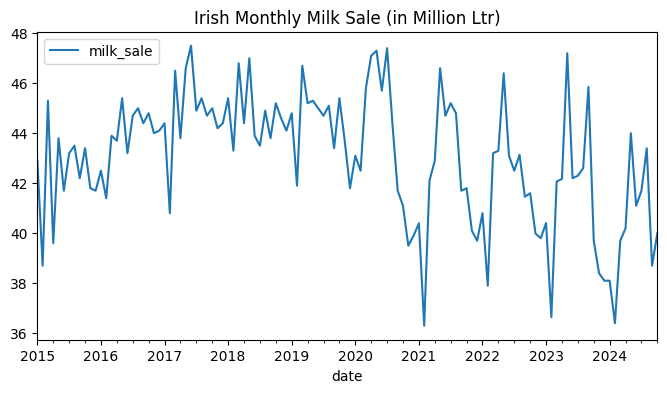

In [38]:
df.plot(figsize = (8,4))
plt.title('Irish Monthly Milk Sale (in Million Ltr)')
plt.show()

#### Frequency distribution graph

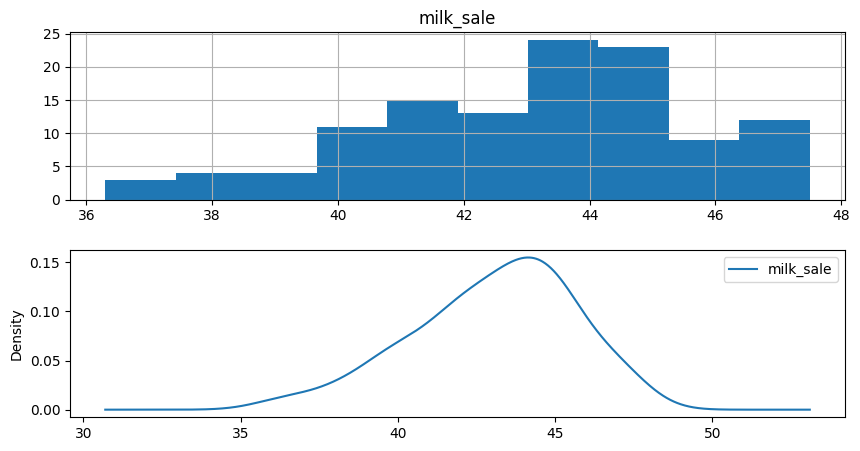

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))
df.hist(ax = ax1)
df.plot(kind = 'kde', ax = ax2)
plt.show()

#### Decomposition plot to visualize the structure of time series

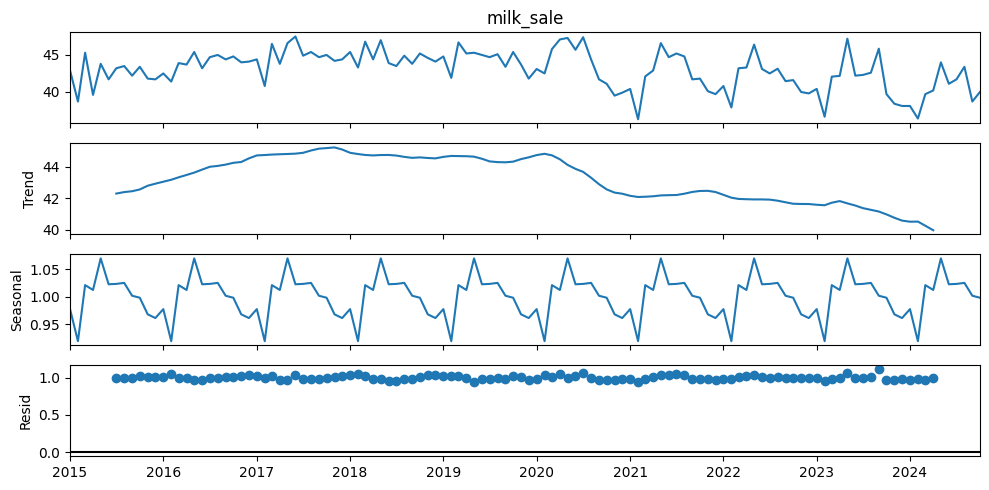

In [40]:
decomposition = seasonal_decompose(df['milk_sale'], period = 12, model = 'multiplicative')
plt.rcParams['figure.figsize'] = 10, 5
decomposition.plot()
plt.show()

#### Plot ACF and PACF for original/non-stationary data

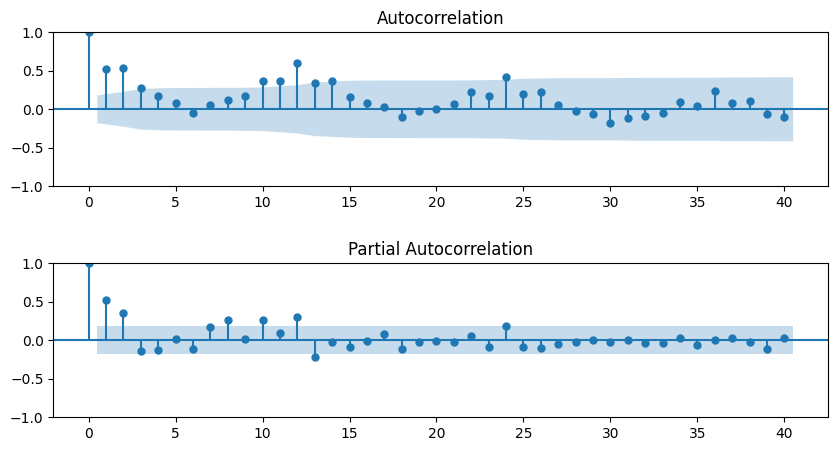

In [41]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))

ax1 = plot_acf(df['milk_sale'], lags = 40, ax = ax1)
ax2 = plot_pacf(df['milk_sale'], lags = 40, ax = ax2)

plt.subplots_adjust(hspace = 0.5)
plt.show()

### Step 5 : Time Series Algorithms / Modelling

#### Write ADF function to check stationarity

In [42]:
def adfuller_test(data):
    result = adfuller(data)
    labels = ['ADF Test Statistic','p-value','#Lags Used','#Observation Used']
    for value,label in zip(result,labels):
        print(label  + ': ' + str(value))
    if result[1]<=0.05:
        print('Strong evidence against the null hypothesis, hence REJECT Ho. and the series is Stationary')
    else:
        print('Weak evidence against null hypothesis, hence ACCEPT Ho. and the series is Not Stationary.')

In [43]:
adfuller_test(df['milk_sale'])

ADF Test Statistic: 0.17952068424509088
p-value: 0.9710892951171728
#Lags Used: 12
#Observation Used: 105
Weak evidence against null hypothesis, hence ACCEPT Ho. and the series is Not Stationary.


In [44]:
df1 = df.diff(1).diff(12).dropna()

In [45]:
adfuller_test(df1['milk_sale'])

ADF Test Statistic: -4.753272329666176
p-value: 6.675785145919837e-05
#Lags Used: 11
#Observation Used: 92
Strong evidence against the null hypothesis, hence REJECT Ho. and the series is Stationary


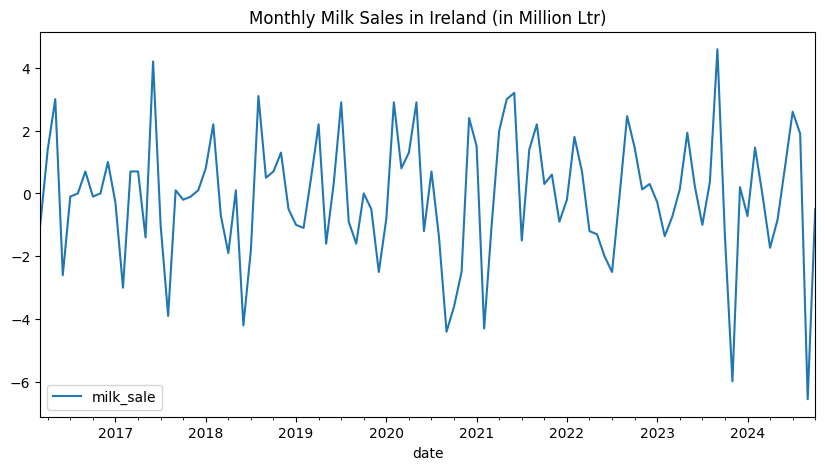

In [46]:
df1.plot(figsize=(10,5))
plt.title('Monthly Milk Sales in Ireland (in Million Ltr)')
plt.show()

#### Compare stationary and non-stationary data

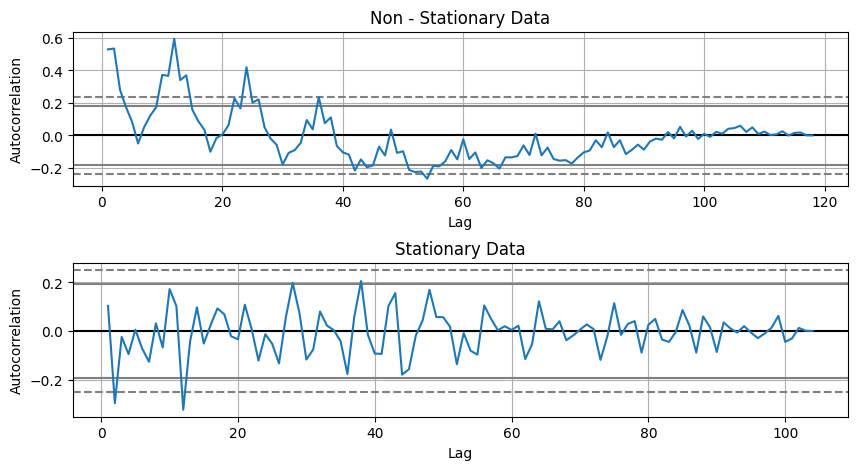

In [47]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))

ax1 = autocorrelation_plot(df['milk_sale'], ax = ax1)
ax1.set_title('Non - Stationary Data')

ax2 = autocorrelation_plot(df1['milk_sale'], ax = ax2)
ax2.set_title('Stationary Data')

plt.subplots_adjust(hspace = 0.5)
plt.show()

#### Compare ACF and PACF for stationary data

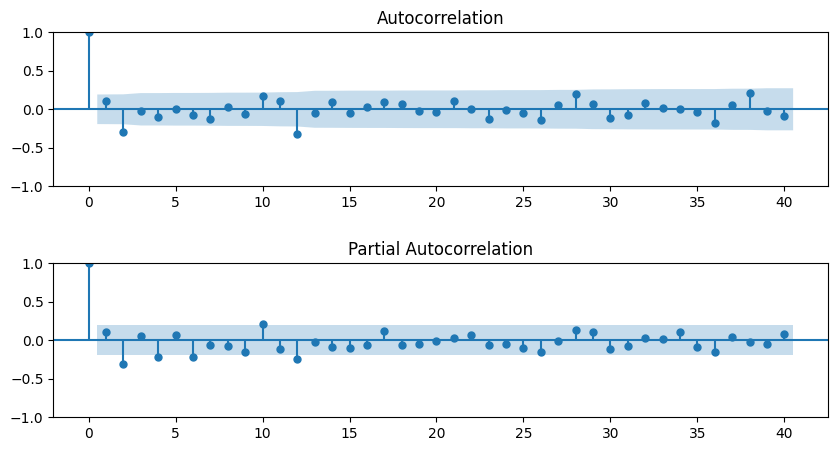

In [48]:
fig, (ax1, ax2) = plt.subplots(nrows = 2, ncols = 1, sharex = False, sharey = False, figsize = (10,5))

ax1 = plot_acf(df1['milk_sale'], lags = 40, ax = ax1)
ax2 = plot_pacf(df1['milk_sale'], lags = 40, ax = ax2)

plt.subplots_adjust(hspace = 0.5)
plt.show()

#### Run Auto-Arima model to find optimal values of parameters (p,d,q)

In [49]:
model = pm.auto_arima(df['milk_sale'], d = 1, D = 1,
                      seasonal = True, m = 12, 
                      start_p = 2, start_q = 2, max_order = 6, test = 'adf', trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=395.477, Time=1.52 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=458.199, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=404.185, Time=0.28 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=392.619, Time=0.15 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=418.542, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=394.527, Time=0.36 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=394.533, Time=0.70 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=399.534, Time=0.05 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.10 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=416.056, Time=0.15 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=393.223, Time=0.51 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=394.414, Time=0.29 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=397.109, Time=0.18 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=396.569, Time=0.64 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   

##### We have got best parameter values ARIMA(0,1,1)(0,1,1)[12]  

In [50]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  118
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -193.310
Date:                            Sun, 05 Jan 2025   AIC                            392.619
Time:                                    12:13:24   BIC                            400.581
Sample:                                01-01-2015   HQIC                           395.845
                                     - 10-01-2024                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5761      0.066     -8.681      0.000      -0.706      -0.446
ma.S.L12      -0.6153      0.089     -6.938      0.000      -0.789      -0.441
sigma2         2.1946      0.245      8.965      0.000       1.715       2.674
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                13.87
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.63   Skew:                             0.43
Prob(H) (two-sided):                  0.16   Kurtosis:                         4.56
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Split the data into train and test sets (75%)

In [51]:
train = df[:round(len(df) * 75 / 100)]
test = df[round(len(df) * 75 / 100):]

train.shape,test.shape


((88, 1), (30, 1))

#### Implement SARIMAX model (Use the best parameters obtained in Auto-Arima)

In [52]:
model = SARIMAX(train['milk_sale'],order=(0,1,1),seasonal_order=(0,1,1,12))
results = model.fit(disp = False)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                          milk_sale   No. Observations:                   88
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -133.084
Date:                            Sun, 05 Jan 2025   AIC                            272.168
Time:                                    12:13:25   BIC                            279.121
Sample:                                01-01-2015   HQIC                           274.944
                                     - 04-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3982      0.089     -4.469      0.000      -0.573      -0.224
ma.S.L12      -0.5940      0.136     -4.362      0.000      -0.861      -0.327
sigma2         1.8950      0.291      6.503      0.000       1.324       2.466
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 2.65
Prob(Q):                              0.81   Prob(JB):                         0.27
Heteroskedasticity (H):               1.34   Skew:                             0.25
Prob(H) (two-sided):                  0.47   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Plot Residual stats (Train Set)

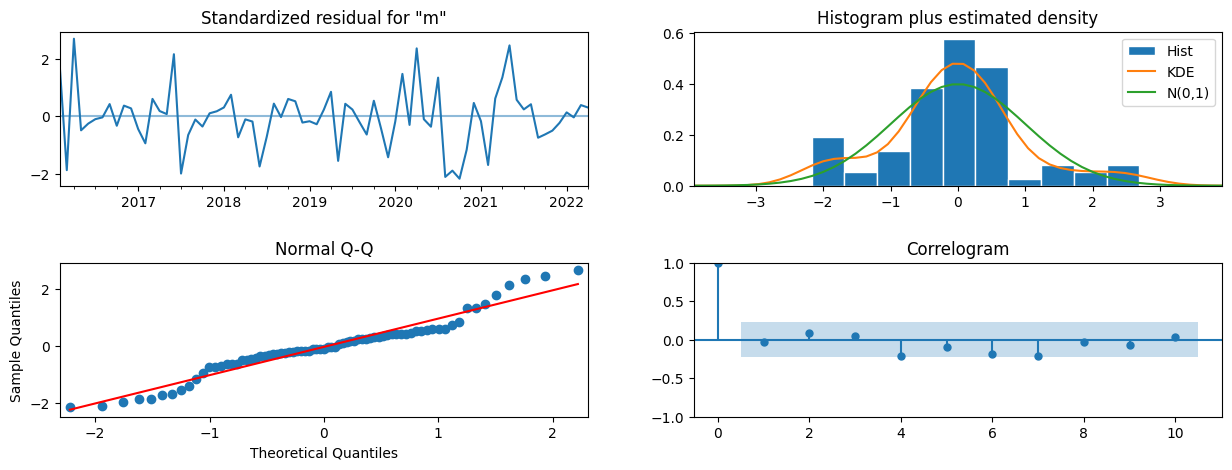

In [53]:
results.plot_diagnostics(figsize = (15,5))
plt.subplots_adjust(hspace = 0.5)
plt.show()


#### Predicting the milk sales for the test dataset

In [54]:
start = len(train)
end = len(train) + len(test) - 1
predictions = results.predict(start = start, end = end , dynamic = False, typ = 'levels').rename('SARIMA (0,1,1) (0,1,1,12) Test Predictions')

In [55]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10} , expected = {test['milk_sale'][i]}")

predicted=45.26351257 , expected = 46.4
predicted=43.6982638  , expected = 43.1
predicted=44.19084322 , expected = 42.5
predicted=43.52856443 , expected = 43.14
predicted=41.17506729 , expected = 41.46
predicted=41.54707905 , expected = 41.6
predicted=40.05182355 , expected = 39.99
predicted=39.67906881 , expected = 39.8
predicted=40.59524511 , expected = 40.41
predicted=37.77186895 , expected = 36.64
predicted=42.74325383 , expected = 42.07
predicted=42.72299017 , expected = 42.17
predicted=44.78437722 , expected = 47.2
predicted=43.21912844 , expected = 42.2
predicted=43.71170787 , expected = 42.3
predicted=43.04942908 , expected = 42.6
predicted=40.69593194 , expected = 45.85
predicted=41.06794369 , expected = 39.7
predicted=39.5726882  , expected = 38.4
predicted=39.19993346 , expected = 38.1
predicted=40.11610976 , expected = 38.1
predicted=37.29273359 , expected = 36.4
predicted=42.26411847 , expected = 39.7
predicted=42.24385481 , expected = 40.2
predicted=44.30524186 , expected

### ------Plot Actual Vs Predicted milk sale (Test Set)-------

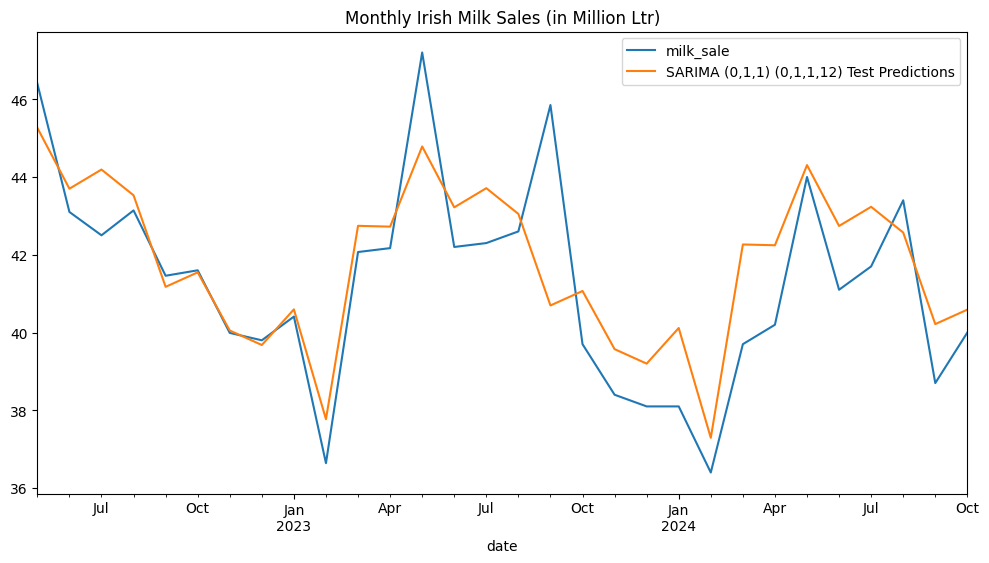

In [56]:
title = 'Monthly Irish Milk Sales (in Million Ltr)'
ax = test['milk_sale'].plot(legend = True, figsize = (12,6), title = title)
predictions.plot(legend = True)
ax.autoscale(axis = 'x', tight = True)

### Step 6 : Evaluation and Forecasting

In [57]:
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['milk_sale'], predictions)},index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['milk_sale'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['milk_sale'], predictions)
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['milk_sale'])/np.abs(test['milk_sale']))*100
evaluation_results

,r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
0,0.64604,1.163286,2.366898,2.798371


### ____________Forecasting milk sales (in million ltr) for next 12 months____________

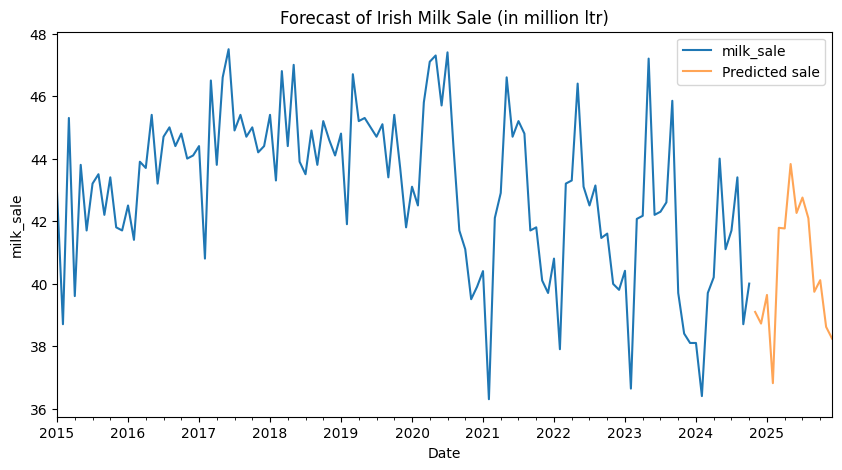

Forecasting milk sales graph is saved successfully at C:\Users\NACHIKET\Downloads\Irish_Milk_Sale_Forecast.png


In [58]:
forecast = results.get_prediction(start = '2024-11-01', end = '2025-12-01')
idx = np.arange(len(forecast.predicted_mean))
forecast_values = forecast.predicted_mean
forecast_ci = forecast.conf_int()
fig, ax = plt.subplots()
df.plot(ax = ax, label='observed' )
forecast_values.plot(ax = ax, label = 'Predicted sale', alpha = 0.7)
ax.set_xlabel('Date')
ax.set_ylabel('milk_sale')
plt.legend()
ax.set_title('Forecast of Irish Milk Sale (in million ltr)')
# Save the figure to the local drive
file_path = r"C:\Users\NACHIKET\Downloads\Irish_Milk_Sale_Forecast.png"
plt.savefig(file_path, dpi=300, bbox_inches='tight')
# Display the plot
plt.show()
print(f"Forecasting milk sales graph is saved successfully at {file_path}")
plt.show()

### ____Conclusion_____
#### In this analysis, we utilized a publicly available milk sales dataset from DATA.GOVE.IE to forecast monthly Irish milk sales. The dataset was preprocessed and visualized to uncover its underlying trends and seasonality. Stationarity analysis was conducted to ensure the data met the prerequisites for time series modeling. Using ACF and PACF plots, we identified significant time lags influencing the data. The Auto-ARIMA method was employed to determine the optimal parameter values, and the SARIMAX model was implemented to generate accurate forecasts. These results demonstrate the effectiveness of time series analysis techniques for predicting and understanding sales patterns.

In [60]:
import sys
print(sys.version)

3.12.2 (main, Sep  6 2024, 08:07:10) [MSC v.1929 64 bit (AMD64)]
